## Imports

In [31]:
import torch
import pandas as pd
import os
from torchvision import transforms
from EmotionDataset import EmotionDataset, get_transform
from EmotionCNN import EmotionCNN
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from PIL import Image
from torchvision.transforms import (
    RandomHorizontalFlip,
    RandomRotation,
    RandomAdjustSharpness,
    ToTensor,
    RandomResizedCrop,
)

## Data Preprocessing

In [2]:
# Load and prepare the dataset
dataset_path = os.path.join(os.getcwd(), 'data')
labels_path = os.path.join(dataset_path, 'labels.csv')
df = pd.read_csv(labels_path)

df['label'] = df['pth'].apply(lambda x: x.split('/')[0])
label_to_int = {label: idx for idx, label in enumerate(df['label'].unique())}
int_to_label = {v: k for k, v in label_to_int.items()}
df['label'] = df['label'].map(label_to_int)
df['pth'] = df['pth'].apply(lambda x: os.path.join(dataset_path, x))
df = df[['pth', 'label']]  # Only use path and integer label

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
print(df.head())

                                                 pth  label
0  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      2
1  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      0
2  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      3
3  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      2
4  c:\Users\jaryd\OneDrive\Coding Projects\ECS174...      3


### Class Distributions

In [4]:
# Create a DataFrame to display the distributions with label names
train_dist = train_df['label'].value_counts().reset_index()
train_dist.columns = ['label', 'count']
train_dist['emotion'] = train_dist['label'].map(int_to_label)

test_dist = test_df['label'].value_counts().reset_index()
test_dist.columns = ['label', 'count']
test_dist['emotion'] = test_dist['label'].map(int_to_label)

In [5]:
# Print Distributions
print("Training set class distribution before oversampling:\n")
print(train_dist[['label', 'emotion', 'count']])
print("\n--------------------------------------------")
print("\nTesting set class distribution:\n")
print(test_dist[['label', 'emotion', 'count']])

Training set class distribution before oversampling:

   label   emotion  count
0      5   neutral   4089
1      4     happy   4016
2      7  surprise   3141
3      0     anger   2447
4      3      fear   2372
5      6       sad   2344
6      1  contempt   2216
7      2   disgust   1915

--------------------------------------------

Testing set class distribution:

   label   emotion  count
0      4     happy   1027
1      5   neutral   1025
2      7  surprise    796
3      3      fear    607
4      6       sad    590
5      0     anger    587
6      1  contempt    541
7      2   disgust    462


In [6]:
# Use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Oversample minority classes
ros = RandomOverSampler(random_state=42)
X_train = train_df['pth'].values.reshape(-1, 1)
y_train = train_df['label'].values
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Convert back to DataFrame
train_resampled_df = pd.DataFrame({
    'pth': X_resampled.flatten(),
    'label': y_resampled
})

### Class Distributions After Oversampling

In [8]:
# Print the distribution after oversampling
train_resampled_dist = train_resampled_df['label'].value_counts().reset_index()
train_resampled_dist.columns = ['label', 'count']
train_resampled_dist['emotion'] = train_resampled_dist['label'].map(int_to_label)

print("\nTraining set class distribution after oversampling:\n")
print(train_resampled_dist[['label', 'emotion', 'count']])


Training set class distribution after oversampling:

   label   emotion  count
0      2   disgust   4089
1      7  surprise   4089
2      0     anger   4089
3      5   neutral   4089
4      4     happy   4089
5      3      fear   4089
6      1  contempt   4089
7      6       sad   4089


In [9]:
# Transform for the first epoch
transform_initial = get_transform()

# Data augmentation for epochs after first
transform_augmented = transforms.Compose([
    RandomHorizontalFlip(),
    RandomRotation(15),
    RandomResizedCrop(96, scale=(0.9, 1.0)),
    RandomAdjustSharpness(2),
    ToTensor()
])

In [10]:
# Create the datasets
train_dataset = EmotionDataset(train_resampled_df, transform_initial)
test_dataset = EmotionDataset(test_df, get_transform())

In [11]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# Initialize the model, optimizer, and criterion
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [13]:
def calculate_accuracy(outputs, labels):
    _, predictions = torch.max(outputs, 1)
    return (predictions == labels).float().mean().item()

## Model Training

In [14]:
# Lists to store metrics
train_losses = []
train_accuracies = []
test_accuracies = []

# Variables to store the best model
best_test_accuracy = 0.0
best_model_path = './models/best_model'
best_epoch = 0

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # Update the transform after the first epoch
    if epoch > 0:
        train_dataset.transform = transform_augmented
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Save training loss
    train_losses.append(epoch_loss / len(train_loader))

    # Evaluate on training set
    model.eval()
    train_accuracy = 0
    with torch.no_grad():
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            train_accuracy += calculate_accuracy(outputs, labels)
    train_accuracy /= len(train_loader)
    train_accuracies.append(train_accuracy)
    
    # Evaluate on testing set
    test_accuracy = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_accuracy += calculate_accuracy(outputs, labels)
    test_accuracy /= len(test_loader)
    test_accuracies.append(test_accuracy)
    
    # Check if this is the best model so far
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_path)  # Save model with the highest accuracy
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, '
          f'Training Accuracy: {train_accuracies[-1]:.4f}, Testing Accuracy: {test_accuracies[-1]:.4f}')

Epoch [1/20], Loss: 1.5183, Training Accuracy: 0.5066, Testing Accuracy: 0.5322
Epoch [2/20], Loss: 1.3845, Training Accuracy: 0.4939, Testing Accuracy: 0.5744
Epoch [3/20], Loss: 1.2768, Training Accuracy: 0.5357, Testing Accuracy: 0.6005
Epoch [4/20], Loss: 1.2102, Training Accuracy: 0.5637, Testing Accuracy: 0.6050
Epoch [5/20], Loss: 1.1579, Training Accuracy: 0.5807, Testing Accuracy: 0.6184
Epoch [6/20], Loss: 1.1292, Training Accuracy: 0.5934, Testing Accuracy: 0.6258
Epoch [7/20], Loss: 1.0942, Training Accuracy: 0.6084, Testing Accuracy: 0.6296
Epoch [8/20], Loss: 1.0654, Training Accuracy: 0.6206, Testing Accuracy: 0.6363
Epoch [9/20], Loss: 1.0521, Training Accuracy: 0.6338, Testing Accuracy: 0.6458
Epoch [10/20], Loss: 1.0255, Training Accuracy: 0.6471, Testing Accuracy: 0.6331
Epoch [11/20], Loss: 1.0057, Training Accuracy: 0.6515, Testing Accuracy: 0.6450
Epoch [12/20], Loss: 0.9854, Training Accuracy: 0.6674, Testing Accuracy: 0.6467
Epoch [13/20], Loss: 0.9648, Training

## Model Evaluation

### Loss and Accuracy

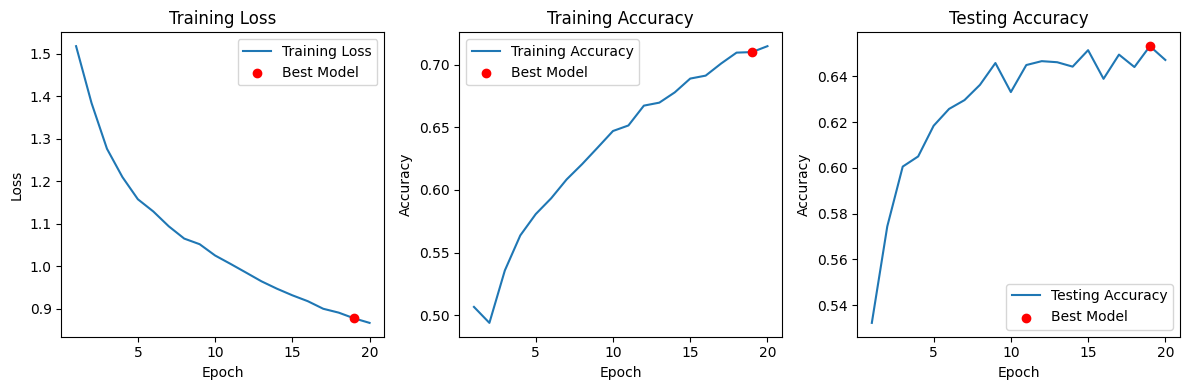

In [57]:
# Plot model evaluation
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.scatter(best_epoch + 1, train_losses[best_epoch], color='red', label='Best Model', zorder=5)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.scatter(best_epoch + 1, train_accuracies[best_epoch], color='red', label='Best Model', zorder=5)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, test_accuracies, label='Testing Accuracy')
plt.scatter(best_epoch + 1, test_accuracies[best_epoch], color='red', label='Best Model', zorder=5)
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# Load model
model_path = './models/best_model'
loaded_model = EmotionCNN().to(device)
loaded_model.load_state_dict(torch.load(model_path, map_location=device))
loaded_model.eval()

EmotionCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=8, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [25]:
# Get the list of class names from the columns
class_names = [int_to_label[i] for i in range(len(int_to_label))]

# Evaluate on testing set and get predictions
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [26]:
# Calculate precision, recall, f1 score
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=1)
recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=1)
f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=1)
final_test_accuracy = accuracy_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)

### More Evaluation Metrics

In [27]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Test Accuracy: {final_test_accuracy:.4f}')

Precision: 0.6480
Recall: 0.6531
F1 Score: 0.6494
Test Accuracy: 0.6531


### Classification Report

In [28]:
# Print classification report for detailed insights
print(classification_report(all_labels, all_predictions, target_names=class_names, zero_division=1))

              precision    recall  f1-score   support

       anger       0.50      0.51      0.50       587
    contempt       0.57      0.64      0.60       541
     disgust       0.45      0.41      0.43       462
        fear       0.52      0.45      0.48       607
       happy       0.90      0.89      0.90      1027
     neutral       0.82      0.89      0.85      1025
         sad       0.52      0.46      0.49       590
    surprise       0.57      0.59      0.58       796

    accuracy                           0.65      5635
   macro avg       0.61      0.61      0.60      5635
weighted avg       0.65      0.65      0.65      5635



### Confusion Matrix

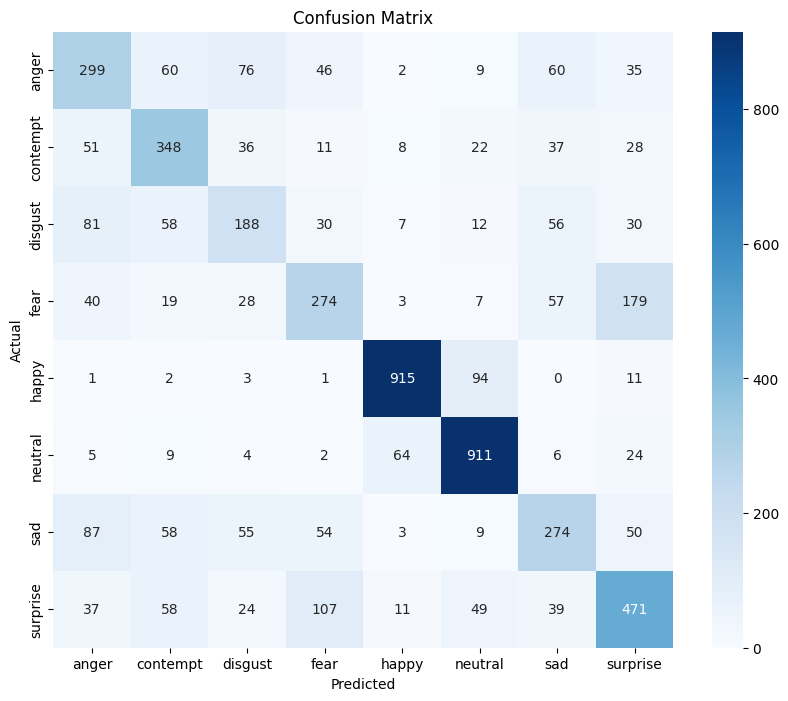

In [29]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Demo

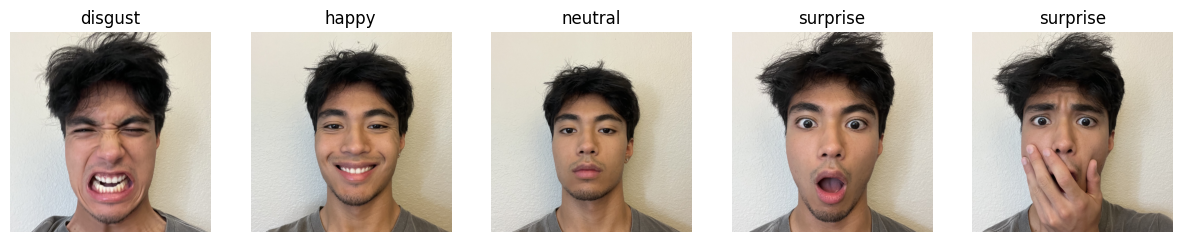

In [56]:
# Path to images directory
images_dir = 'myImages'

# Transform to downsample images
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor()
])

images = []
predictions = []

# Load all images from the directory
for filename in os.listdir(images_dir):
    if filename.endswith('.JPG') or filename.endswith('.jpg'):
        image_path = os.path.join(images_dir, filename)
        original_image = Image.open(image_path).convert('RGB')
        downsampled_image = transform(original_image).unsqueeze(0)  # Downsample images
        downsampled_image = downsampled_image.to(device)
        
        # Get the model's prediction
        with torch.no_grad():
            output = loaded_model(downsampled_image)
            _, predicted_label = torch.max(output, 1)
        
        # Map the predicted label to emotion
        predicted_emotion = int_to_label[predicted_label.item()]
        
        # Store the original image and prediction
        images.append(original_image)
        predictions.append(predicted_emotion)

# Plot the images and their predictions
plt.figure(figsize=(15, 5))
for idx, (image, prediction) in enumerate(zip(images, predictions)):
    plt.subplot(1, len(images), idx + 1)
    plt.imshow(image)
    plt.title(prediction)
    plt.axis('off')

plt.show()
